In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
import bnpgmm_runjingdev.hessian_lib as hessian_lib

In [3]:
np.random.seed(53453)

# Load data

In [4]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

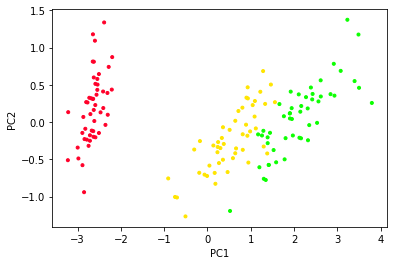

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [6]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


# Get VB params 

In [7]:
k_approx = 2

In [8]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [9]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [10]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1021.8226434034334

## Initialize 

In [11]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
-163.31263464248264


In [12]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

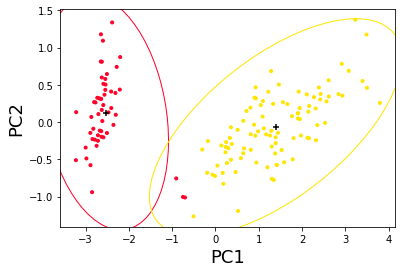

In [13]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [14]:
vb_opt_dict, e_z_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 51
stick_time: 0.341sec
cluster_time: 0.011sec
e_z_time: 0.024sec
**TOTAL time: 0.454sec**


In [15]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [16]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights)


In [17]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [18]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.00741sec


In [19]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.00957sec


In [20]:
# if its impossible, don't run the hessian
run_hessian = True

In [21]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 0.319sec


# estimate hessian

In [22]:
use_bnp_prior = True

In [23]:
# set dictionary at optimal value
vb_params_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                       vb_params_paragami.fold(vb_opt, free = True), 
                                       gh_loc, gh_weights, 
                                        use_bnp_prior=use_bnp_prior)

In [24]:
hessian_components = hessian_lib.HessianComponents(features, vb_params_paragami,
                                                        prior_params_dict, gh_loc, gh_weights,
                                                        use_bnp_prior = use_bnp_prior)

In [25]:
e_z_nat_opt = hessian_components.get_ez_nat(vb_opt)

In [40]:
print(hessian_components.get_kl_objective(vb_opt, e_z_opt))
print(hessian_components.get_kl_objective(vb_opt, e_z_nat_opt, ez_is_nat = True))

-260.8206298210334
-260.8206298210334


In [27]:
dkl_dtheta2 = hessian_components.get_dkl_dtheta2(vb_opt, e_z_opt)

In [28]:
dznat_dtheta = hessian_components.get_dznat_dtheta(vb_opt)

In [29]:
dkl_dtheta_dznat = hessian_components.get_dkl_dtheta_dznat(vb_opt, e_z_nat_opt)

In [30]:
cross_term = np.einsum('ijk, jkl -> il', dkl_dtheta_dznat, dznat_dtheta)
est_hess = dkl_dtheta2 + cross_term

In [31]:
get_dkl_deznat = autograd.grad(hessian_components.get_kl_objective, argnum = 1)
dkl_deznat = get_dkl_deznat(vb_opt, e_z_nat_opt, ez_is_nat = True)
np.abs(dkl_deznat).max()

2.1605437073050756e-09

In [32]:
np.abs(np.einsum('ij, ijk -> k', dkl_deznat, dznat_dtheta)).max()

4.963487136765431e-07

In [33]:
np.abs(hess - est_hess).max()

2.1820738140831963e-06

In [37]:
_cross_term = hessian_components.get_cross_term(vb_opt)

In [39]:
np.abs(_cross_term - cross_term).max()

6.808789643208968e-16

In [34]:
get_dkl_deznat2 = autograd.jacobian(get_dkl_deznat, argnum = 1)
dkl_deznat2 = get_dkl_deznat2(vb_opt, e_z_nat_opt, ez_is_nat = True)

In [35]:
_correction = np.einsum('ijkl, klm -> ijm', dkl_deznat2, dznat_dtheta)
correction = np.einsum('klm, kln -> mn', dznat_dtheta, _correction)

In [36]:
hoo = lambda x : np.einsum('ij, ijk -> k', dkl_deznat, hessian_components.get_dznat_dtheta(x))
hoo2 = autograd.jacobian(hoo)
correction2 = hoo2(vb_opt)

In [37]:
correction_all = cross_term + correction + correction2

In [38]:
np.abs(hess - (est_hess + correction_all)).max()

6.338041202980094e-12

In [39]:
foo = lambda x : np.einsum('ij, ijk -> k', 
                           get_dkl_deznat(x, hessian_components.get_ez_nat(x), ez_is_nat = True), 
                           hessian_components.get_dznat_dtheta(x))

In [40]:
get_foo_grad = autograd.jacobian(foo)
foo_grad = get_foo_grad(vb_opt)

In [41]:
np.abs(foo_grad).max()

2.182067482977418e-06

In [42]:
np.abs(hess - (foo_grad + est_hess)).max()

6.338041202980094e-12

(array([489.,  79.,  70.,  58.,  60.,  67.,  55.,  17.,   3.,   2.]),
 array([-16.        , -15.51980381, -15.03960762, -14.55941143,
        -14.07921524, -13.59901904, -13.11882285, -12.63862666,
        -12.15843047, -11.67823428, -11.19803809]),
 <a list of 10 Patch objects>)

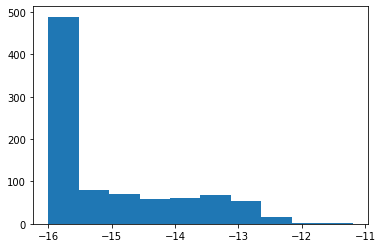

In [43]:
plt.hist(np.log10(np.abs(hess - (foo_grad + est_hess)) + 1e-16).flatten())

In [44]:
np.abs(foo_grad - correction_all).max()

2.0296689403012132e-14

In [60]:
boo = lambda x, w : (hessian_components.get_dznat_dtheta(x) * w).sum()

In [66]:
boo1 = autograd.grad(boo, argnum = 0)
boo2 = autograd.jacobian(boo1, argnum = 1)

In [67]:
dznat_dtheta2 = boo2(vb_opt, np.zeros((150, 2, 30)))

In [68]:
dznat_dtheta2.shape

(30, 150, 2, 30)

In [70]:
dkl_deznat.shape

(150, 2)

In [ ]:
correction2 = 